# PyMC-Marketing Geo-Level MMM

In this post, we build a geo-level Marketing Mix Model (MMM) using `pymc-marketing` on a large-scale dataset to evaluate its performance in estimating true marketing contributions. We'll compare the model's inferred contributions against known ground truth, providing a realistic assessment of its accuracy. Additionally, we profile the model's runtime and memory usage to understand its scalability in production-like settings.

In [1]:
import warnings
from pympler import asizeof

from statsmodels.stats.stattools import durbin_watson
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import time

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

warnings.filterwarnings("ignore", category=UserWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

### The Data

To be replaced with a larger dataset, generated by Luca.

In [3]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"]).rename(columns={"date_week": "date"})

a_data_df = raw_data_df.copy().assign(geo="geo_a")
b_data_df = raw_data_df.copy().assign(geo="geo_b")

# Add noise to the target variable for the second geo
b_data_df["y"] = b_data_df["y"] + 500 * rng.normal(size=len(b_data_df))

# Concatenate the two datasets
data_df = pd.concat([a_data_df, b_data_df])

data_df.head()

date            y        x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  0.318580  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794  0.112388  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  0.292400  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373  0.071399  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  0.386745  0.0      0.0      0.0        120  4   

     geo  
0  geo_a  
1  geo_a  
2  geo_a  
3  geo_a  
4  geo_a

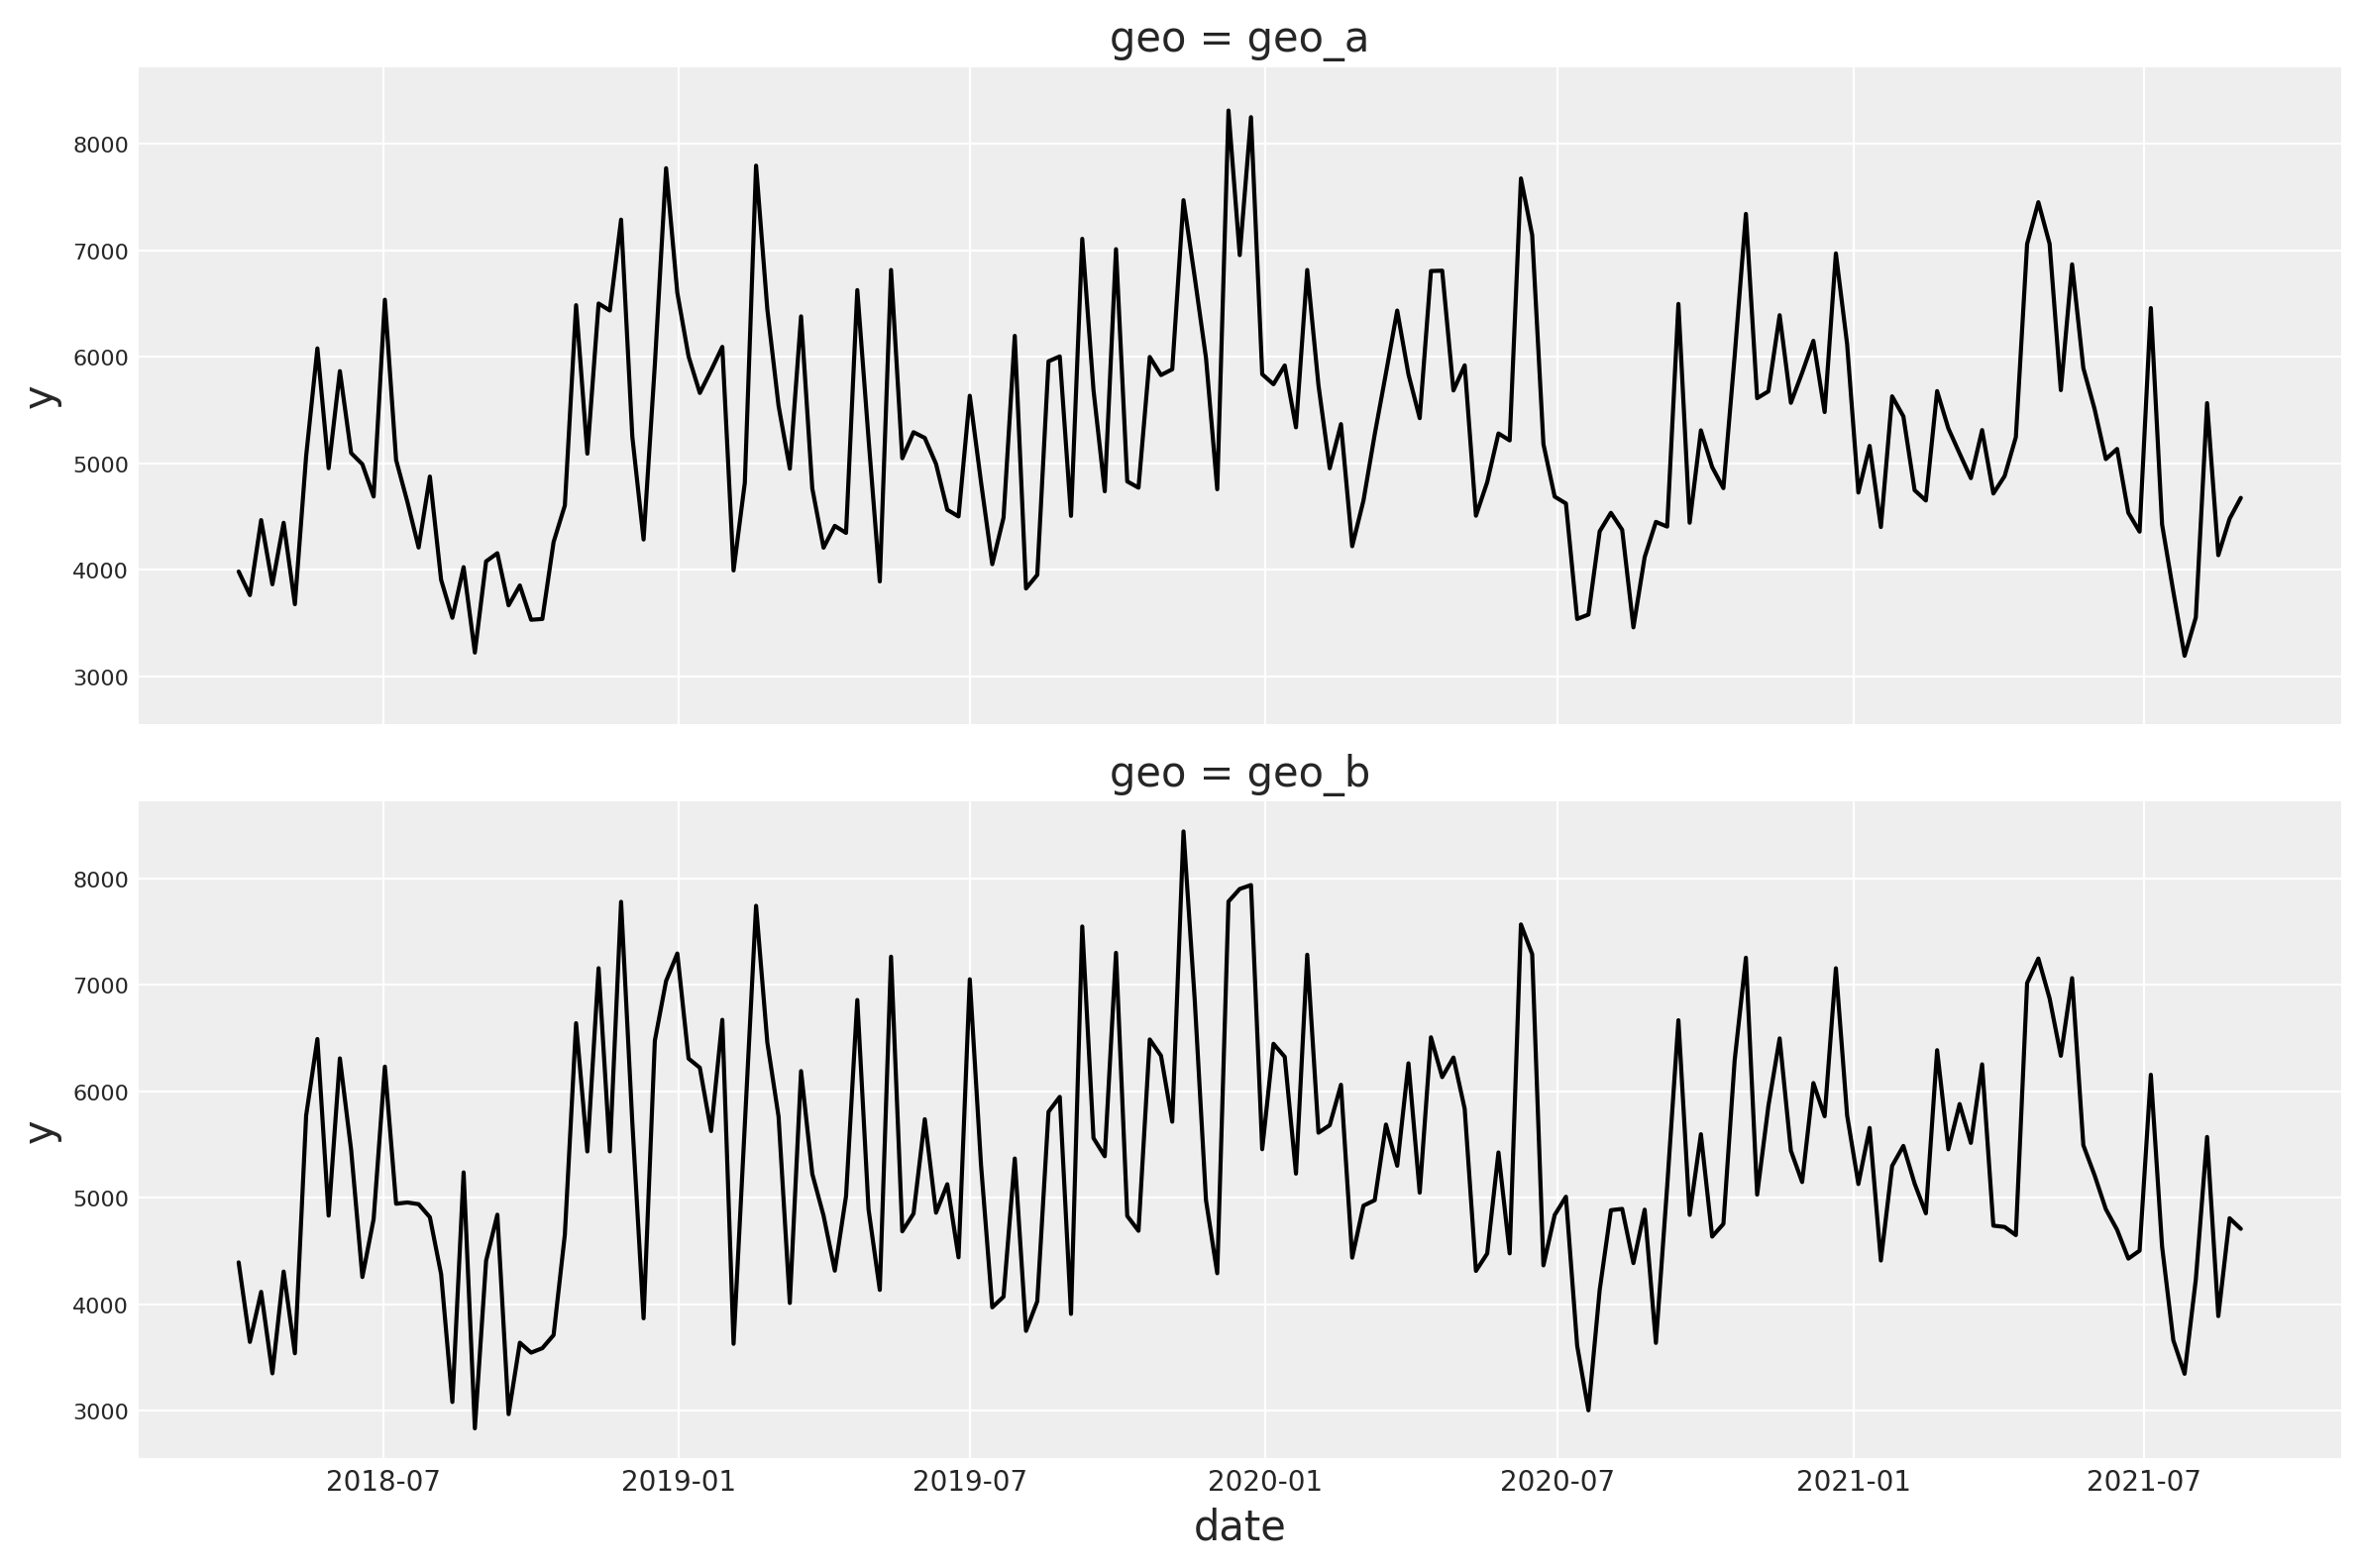

In [4]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

### Prior Specification 

- Using spend shares as prior for $/beta$ parameters, independent across all geo's.
- Hierarchical structure accross the saturation parameters.

In [5]:
channel_columns = ["x1", "x2"]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby(["geo"]).agg({"x1": "sum", "x2": "sum"})

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()
)

prior_sigma = n_channels * spend_share

In [6]:
model_config = {
    'gamma_control': Prior("Normal", mu=0, sigma=2, dims=("control", "geo"))
}

In [7]:
saturation = LogisticSaturation(
    priors={
        "beta": Prior("HalfNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("LogNormal", mu=np.log(3), sigma=np.log(1.5), dims="channel"),
            sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.5), dims="channel"),
            dims=("channel", "geo"),
        ),
    }
)

### Model Specification & Configuration
- Uses default priors across everything but the saturation params.

**Model Specification**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_g + \sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right) + \epsilon_{g,t}
$$

Where:

- $\mu_g$ represents the intercept for geo g.
- $\sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i}$ represents the seasonality/fourier contribution (order 2) at time $t$ for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [8]:
# Base MMM model specification
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    saturation=saturation,
    adstock = GeometricAdstock(l_max = 8),
    yearly_seasonality=2,
    model_config = model_config
)

In [12]:
mmm.model_config

{'intercept': Prior("Normal", mu=0, sigma=2, dims="geo"),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims=("date", "geo")),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims=("control", "geo")),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims=("geo", "fourier_mode")),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3),
 'saturation_lam': Prior("Gamma", mu=Prior("LogNormal", mu=1.0986122886681098, sigma=0.4054651081081644, dims="channel"), sigma=Prior("LogNormal", mu=0.0, sigma=0.4054651081081644, dims="channel"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

### Data Preparation & Model Building

In [9]:
x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

In [10]:
mmm.build_model(X=x_train, y=y_train)

In [11]:
# Add deterministic terms to recover the component contributions in the original scale.
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)

### Prior Predictive Checks

In [13]:
prior_predictive = mmm.sample_prior_predictive(X=x_train, y=y_train, samples=1_000)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma]


In [14]:
scalers = mmm.get_scales_as_xarray()

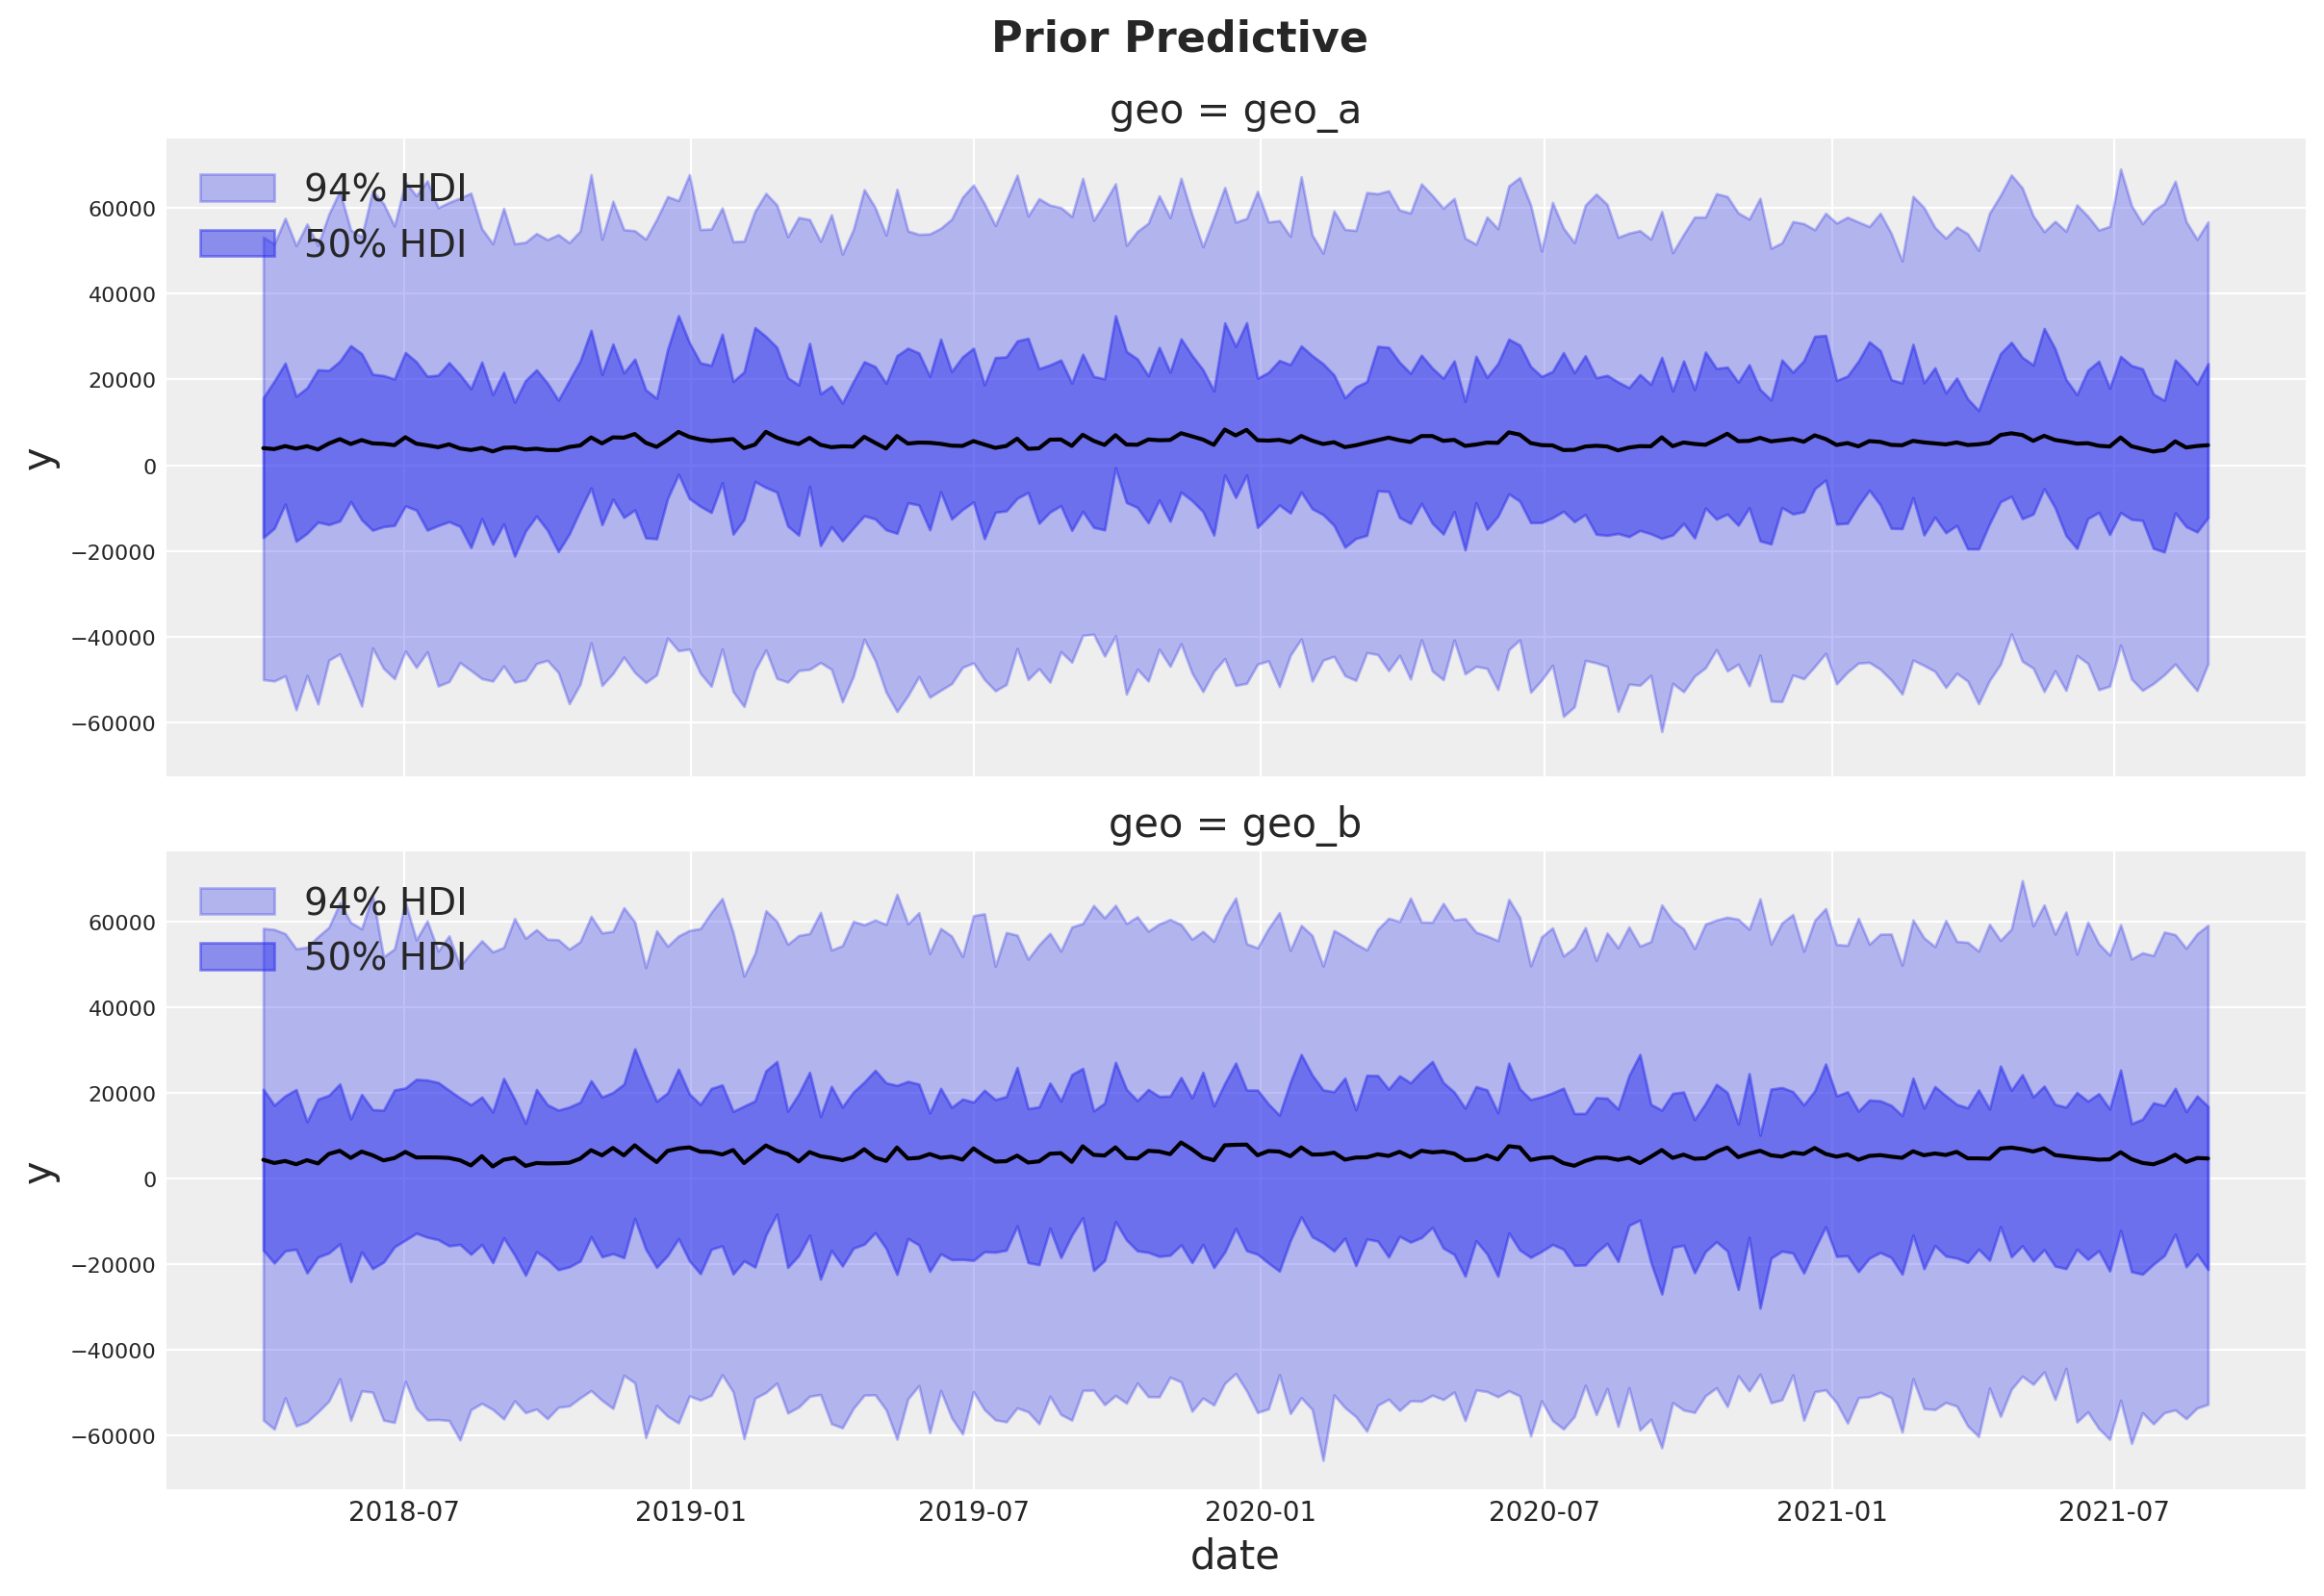

In [15]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

axes = g.axes.flatten()

for ax, geo in zip(axes, mmm.model.coords["geo"], strict=True):
    az.plot_hdi(
        x=mmm.model.coords["date"],
        # We need to scale the prior predictive to the original scale to make it comparable to the data.
        y=(
            prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date")
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        smooth=False,
        color="C0",
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(
            prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date")
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        smooth=False,
        color="C0",
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    ax.legend(loc="upper left")

g.figure.suptitle("Prior Predictive", fontsize=16, fontweight="bold", y=1.03);

### Model Fitting
- Inspects convergence.
- Calculates run speed.
- Calculates memory footprint.

In [16]:
start = time.perf_counter()

mmm.fit(
    X=x_train,
    y=y_train,
    chains=4,
    target_accept=0.95,
    random_seed=rng,
)

end = time.perf_counter()
print(f"Sampling took {end - start:.2f} seconds")

start = time.perf_counter()

mmm.sample_posterior_predictive(
    X=x_train,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

end = time.perf_counter()
print(f"Sampling the posterior predictive took {end - start:.2f} seconds")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam_mu, saturation_lam_sigma, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [y]


Output()

Sampling took 27.00 seconds


Sampling the posterior predictive took 0.20 seconds


In [19]:
divergences = mmm.idata.sample_stats.diverging.sum().item()
print(f"Number of divergences: {divergences}")

r_hat_max = az.summary(
    mmm.idata,
    var_names=[
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam_mu",
        "saturation_lam_sigma",
        "saturation_lam",
        "y_sigma",
    ],
)['r_hat'].max()

print(f"Maximum r_hat: {r_hat_max}")

Number of divergences: 0
Maximum r_hat: 1.01


In [20]:
model_size = asizeof.asizeof(mmm)
print(f"Model size: {model_size / (1024 ** 2):.2f} MB")

Model size: 211.65 MB


### Predictive Performance

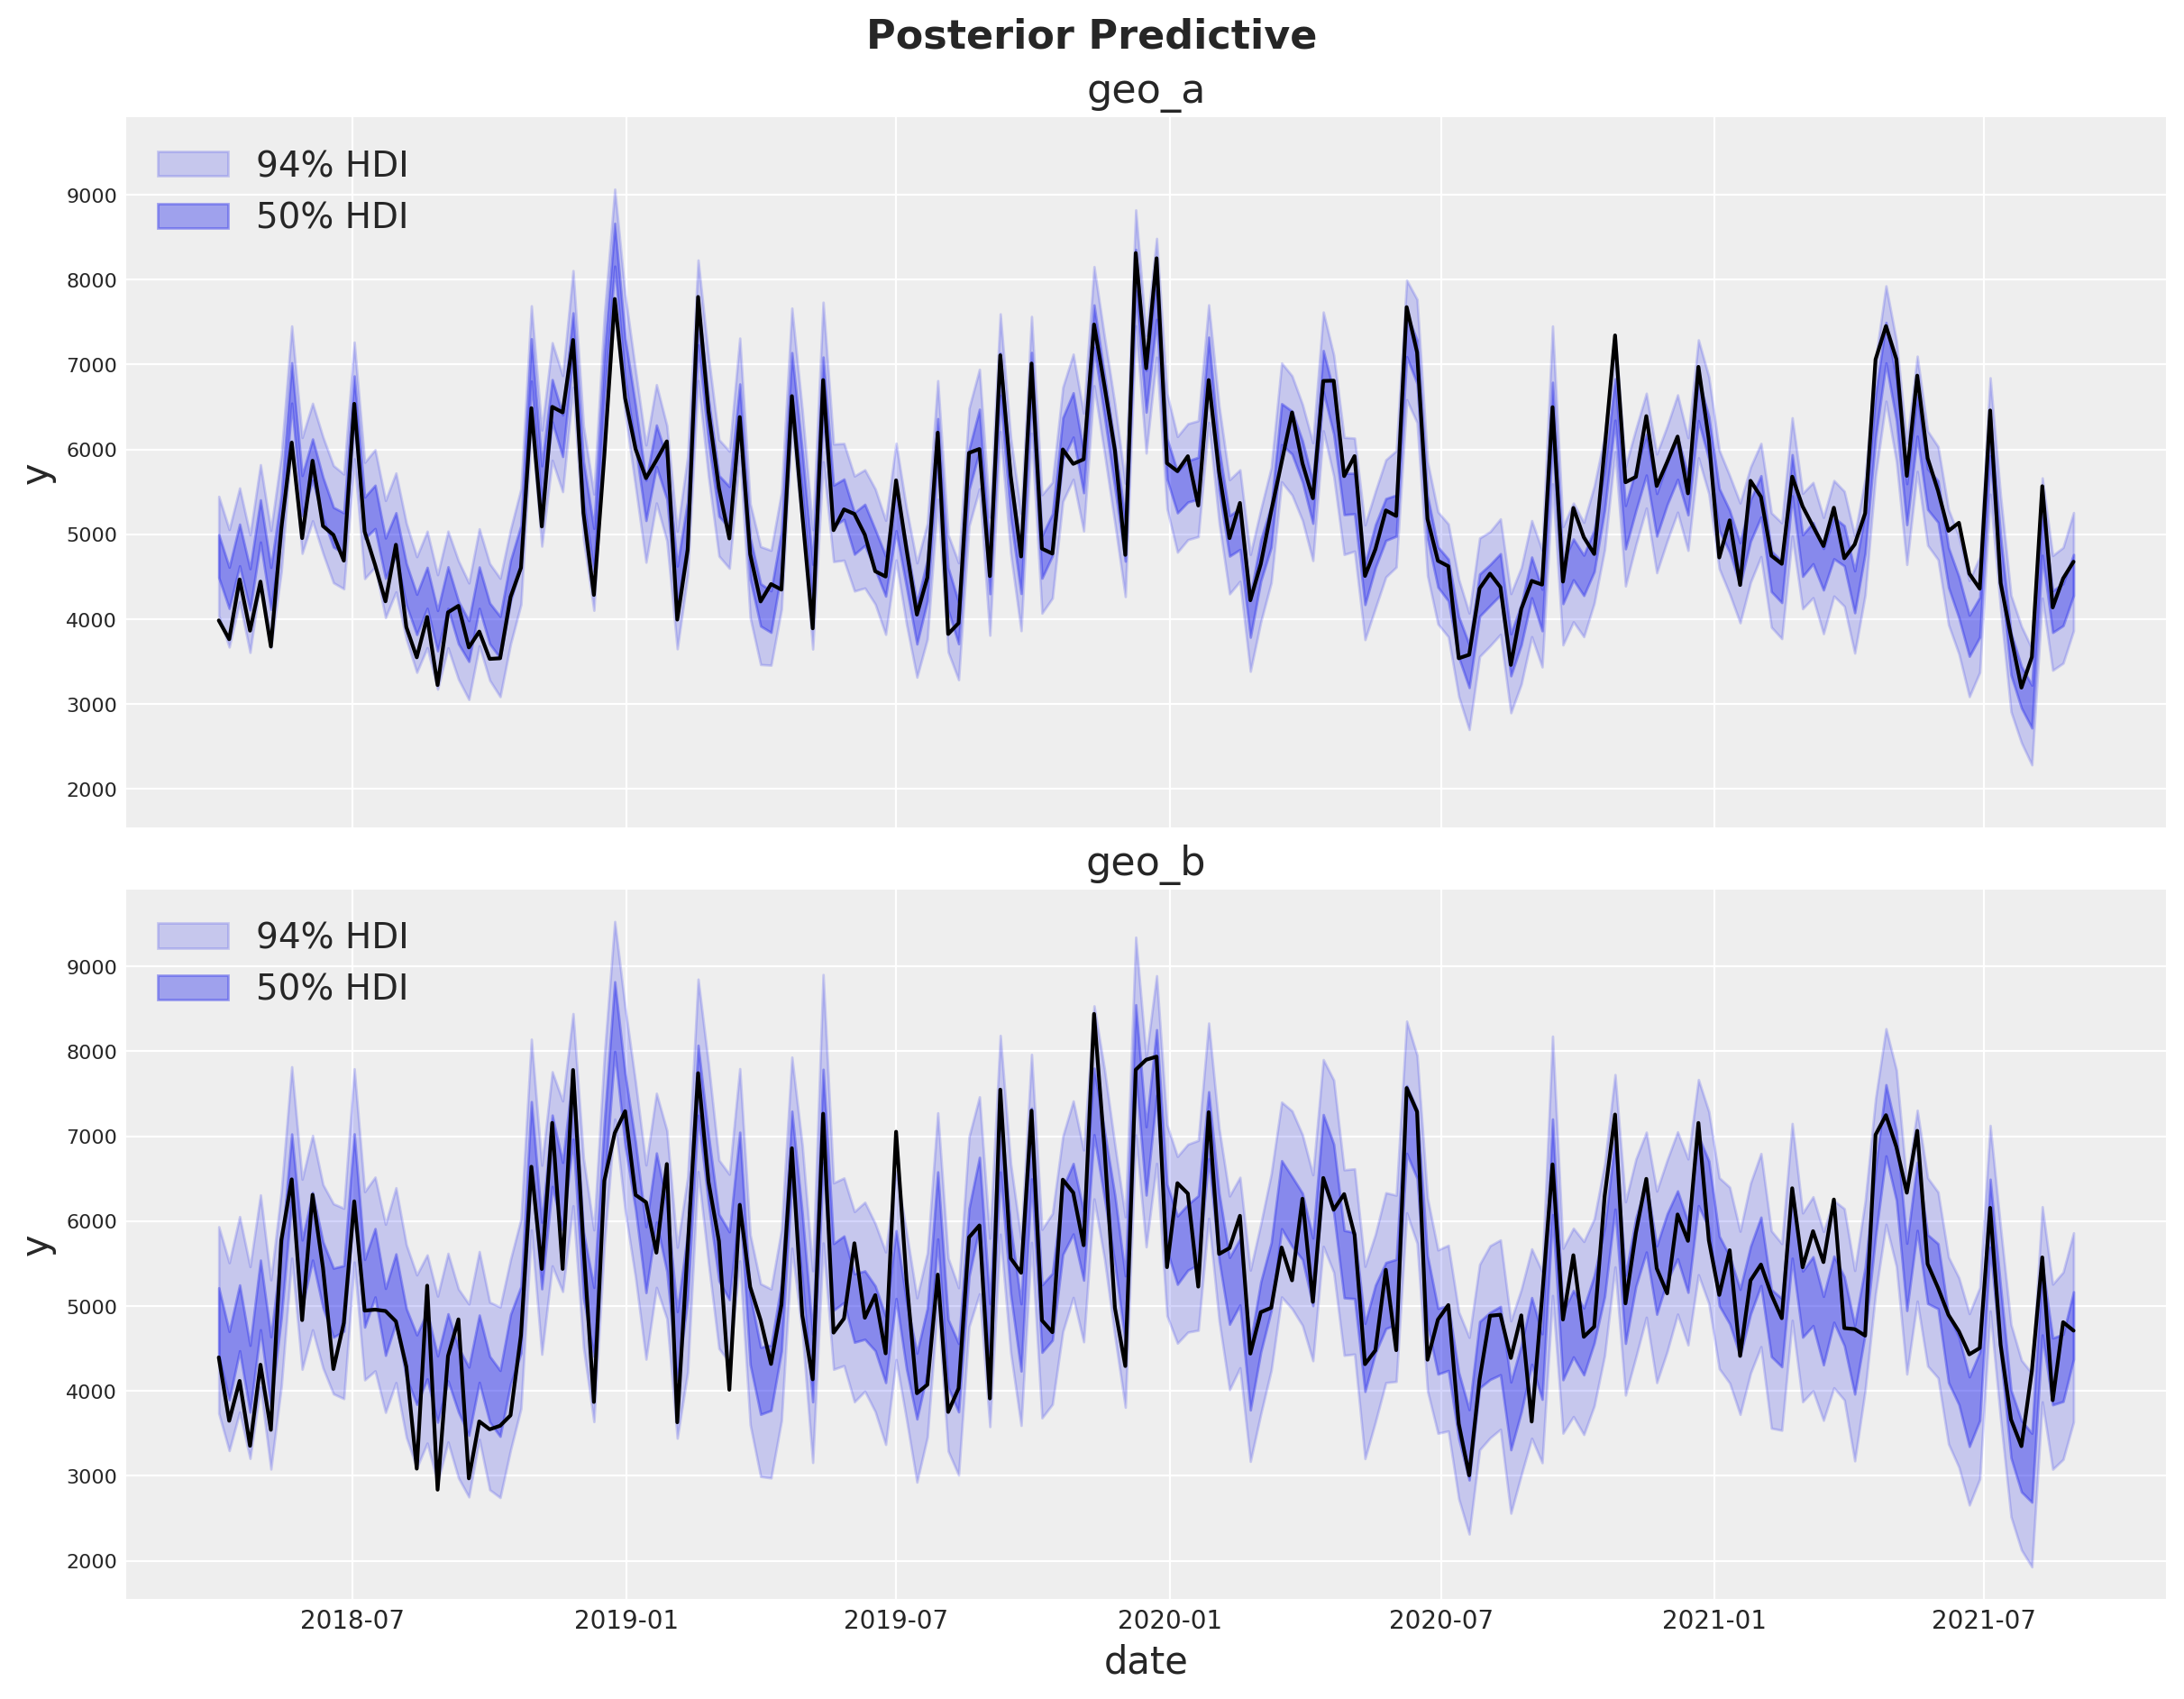

In [21]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(12, 9),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(mmm.idata["posterior_predictive"].y_original_scale.sel(geo=geo)),
        color="C0",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(mmm.idata["posterior_predictive"].y_original_scale.sel(geo=geo)),
        color="C0",
        smooth=False,
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set(title=f"{geo}")

fig.suptitle("Posterior Predictive", fontsize=16, fontweight="bold", y=1.03);

## Media Effectiveness Recovery

- Contributions over time
- ROAS recovery

In [22]:
# Read true contributions
# true_contributions = pd.read_csv("true_output_data.csv")

Example true contributions, to be replaced with the actuals upon Luca generating the data.

In [23]:
# ---------------------------TO BE DELETED ----------------------------

contrib_df = data_df.copy()

# Detect all channel columns starting with 'x'
channel_cols = [col for col in contrib_df.columns if col.startswith("x")]

contrib_col_names = []

for col in channel_cols:
    contrib_col = f"contrib_{col}"
    scaling = np.random.uniform(1000, 2000)
    contrib_df[contrib_col] = contrib_df[col] * scaling
    contrib_col_names.append(contrib_col)

true_contributions = contrib_df[["date", "geo"] + contrib_col_names]

true_contributions.head()
# ---------------------------------------------------------------------

date    geo  contrib_x1  contrib_x2
0 2018-04-02  geo_a  570.333037         0.0
1 2018-04-09  geo_a  201.201762         0.0
2 2018-04-16  geo_a  523.465134         0.0
3 2018-04-23  geo_a  127.820174         0.0
4 2018-04-30  geo_a  692.364636         0.0

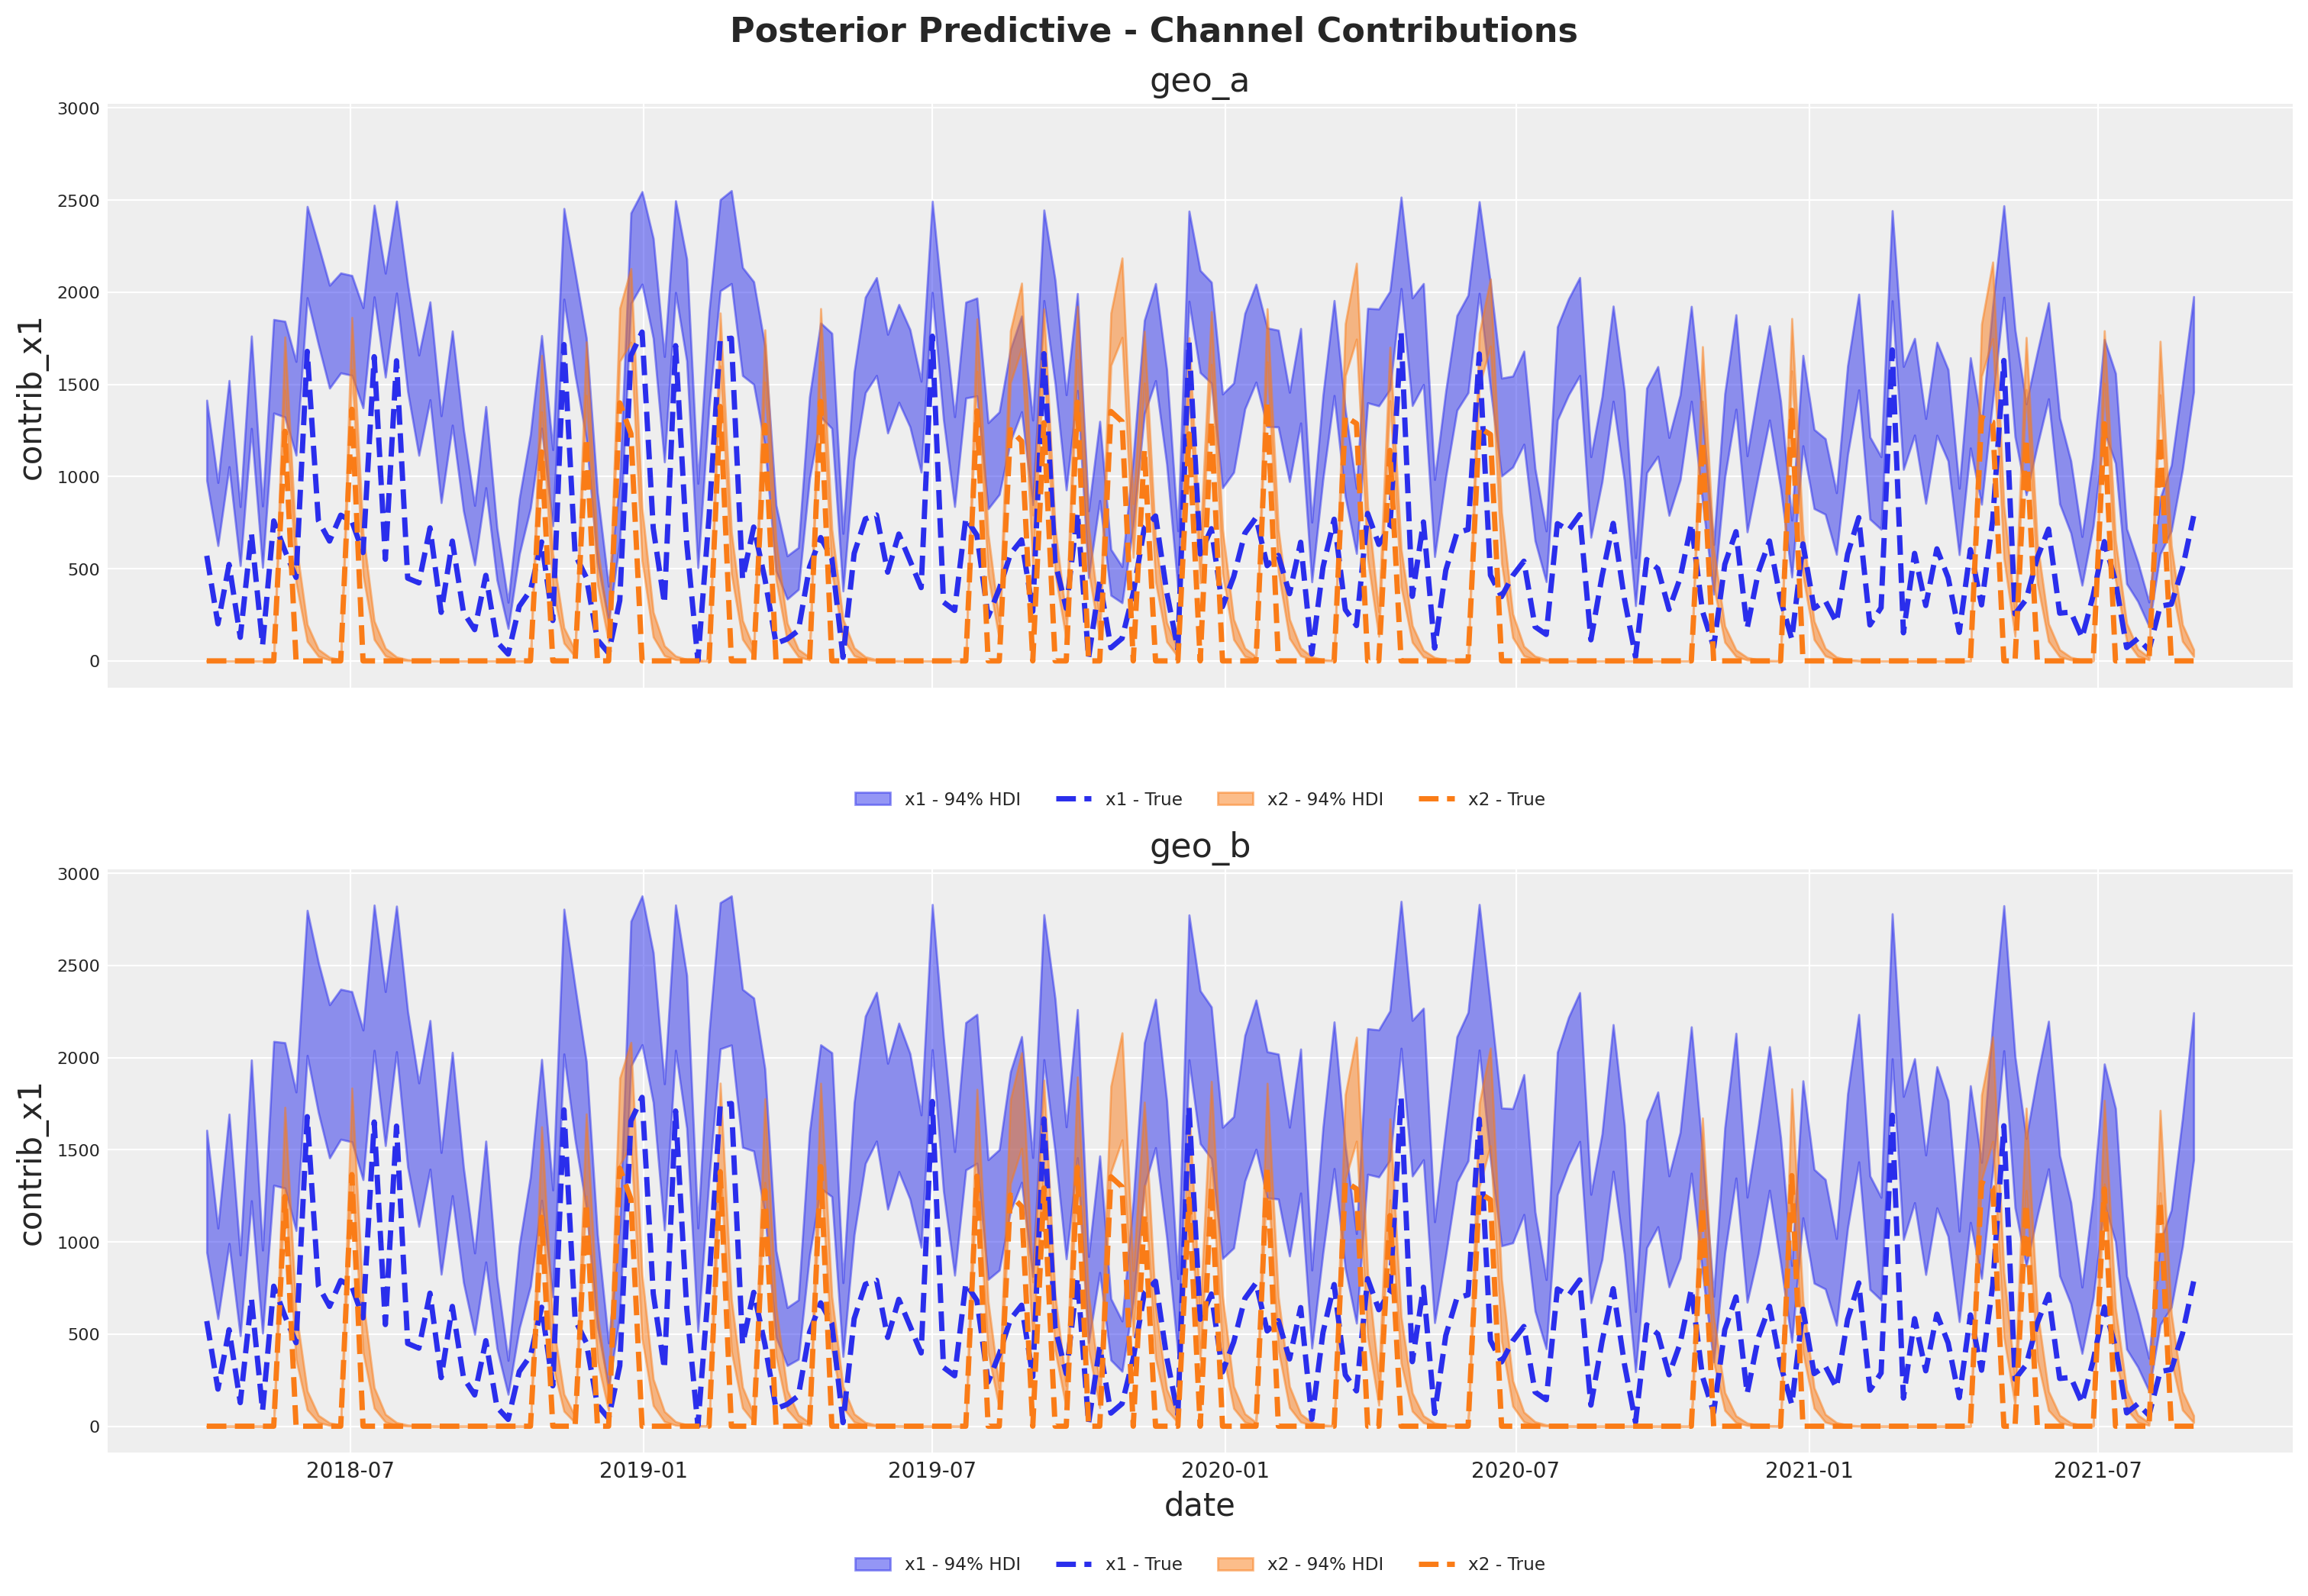

In [24]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(15, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]

    for j, channel in enumerate(mmm.model.coords["channel"]):
        color = f"C{j}"
        label_hdi = f"{channel} - 94% HDI"
        label_true = f"{channel} - True"

        # HDI
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=color,
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": label_hdi},
            ax=ax,
        )

        # True line
        channel_col = f"contrib_{channel}"
        geo_true_df = true_contributions.query("geo == @geo")[["date", channel_col]]
        sns.lineplot(
            data=geo_true_df,
            x="date",
            y=channel_col,
            color=color,
            linestyle="--",
            linewidth=2.5,
            label=label_true,
            ax=ax,
        )

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=4,
        fontsize="small"
    )
    ax.set(title=f"{geo}")

fig.suptitle(
    "Posterior Predictive - Channel Contributions",
    fontsize=16,
    fontweight="bold",
    y=1.03,
);


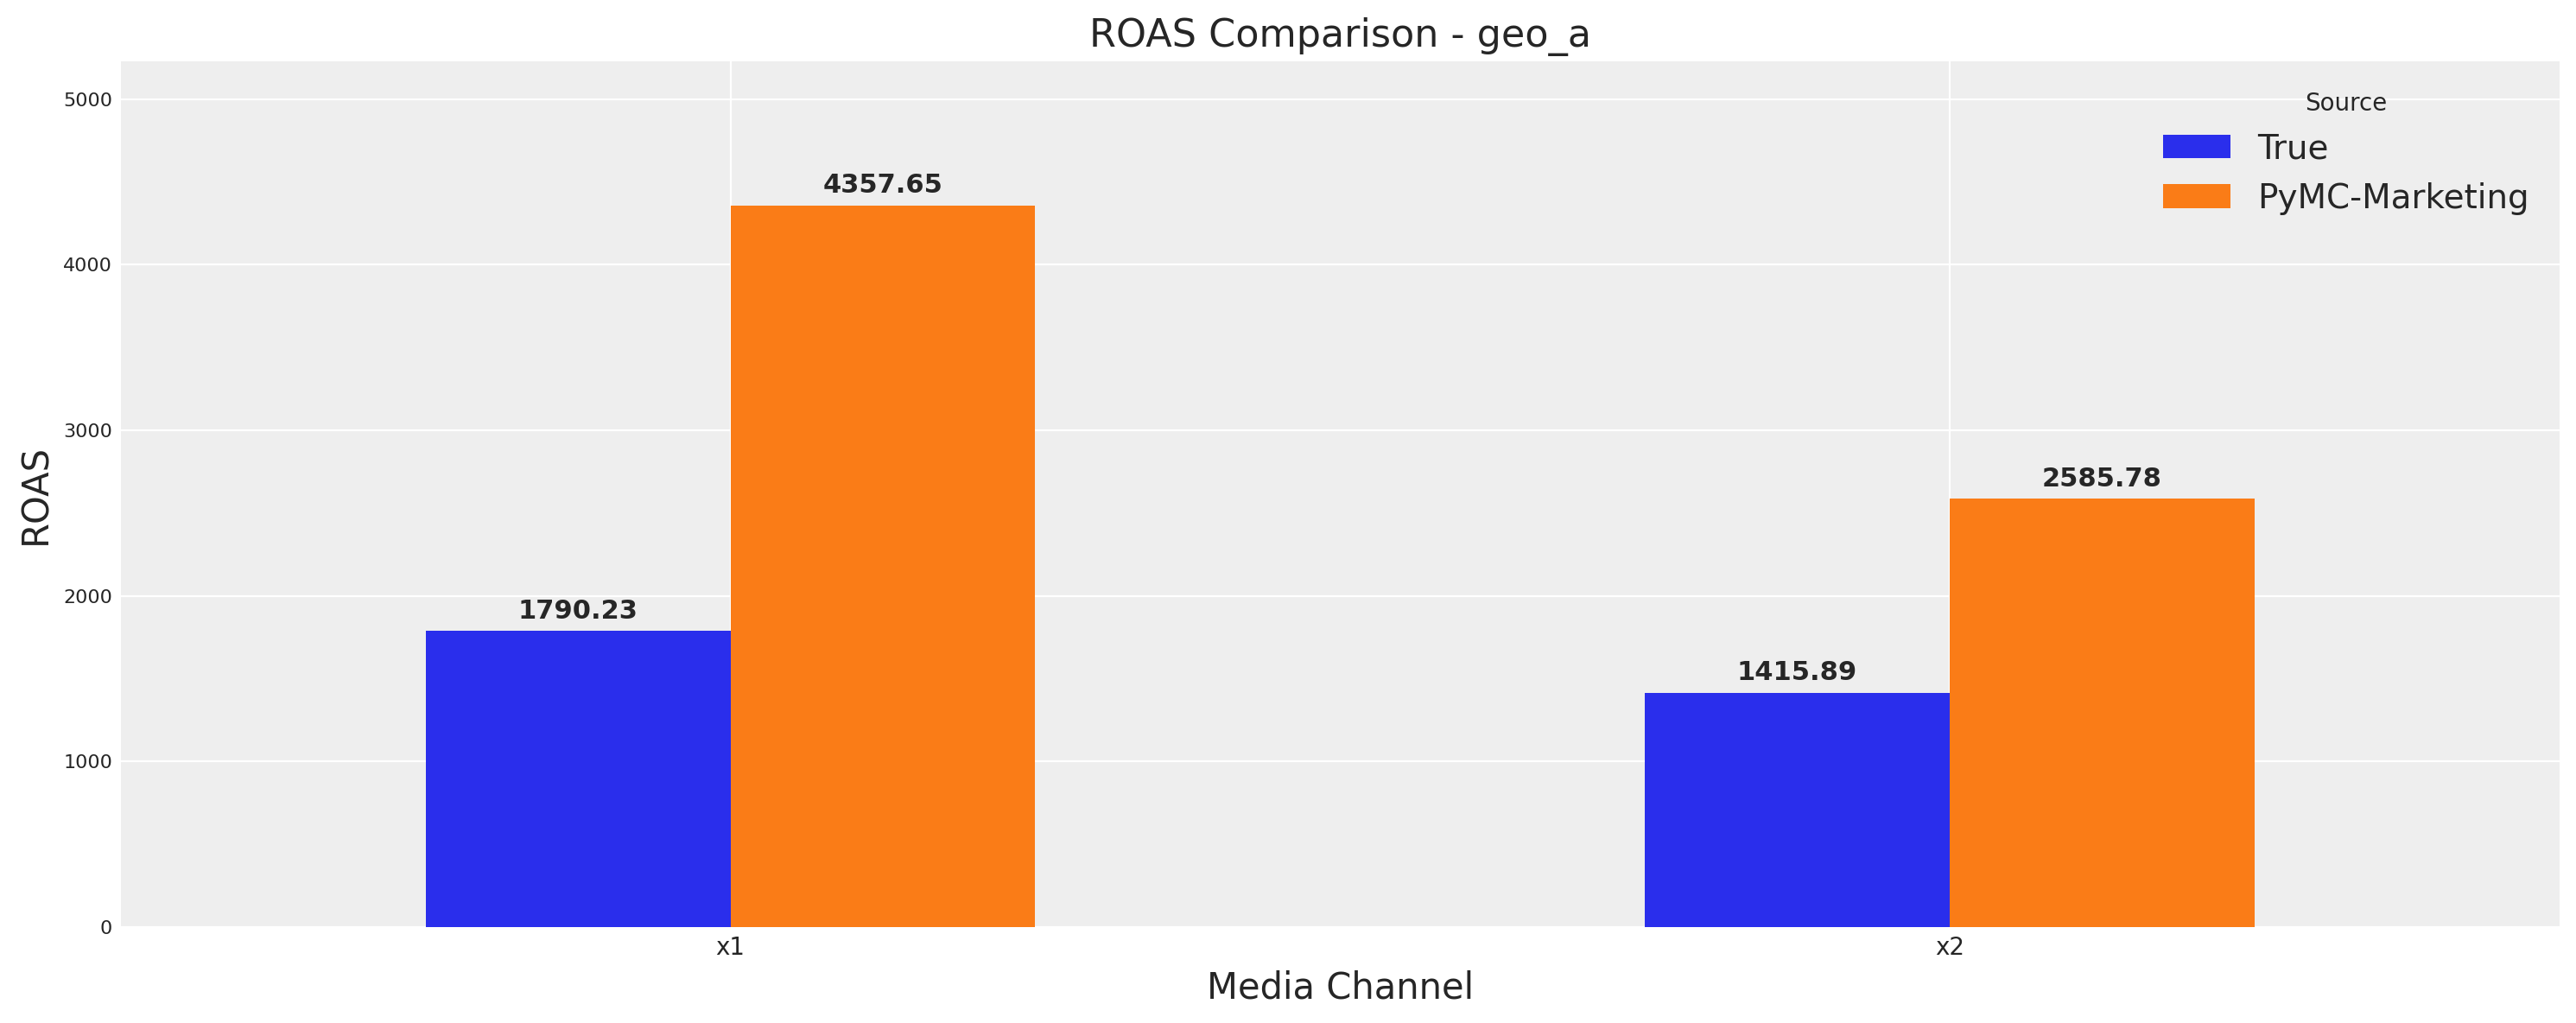

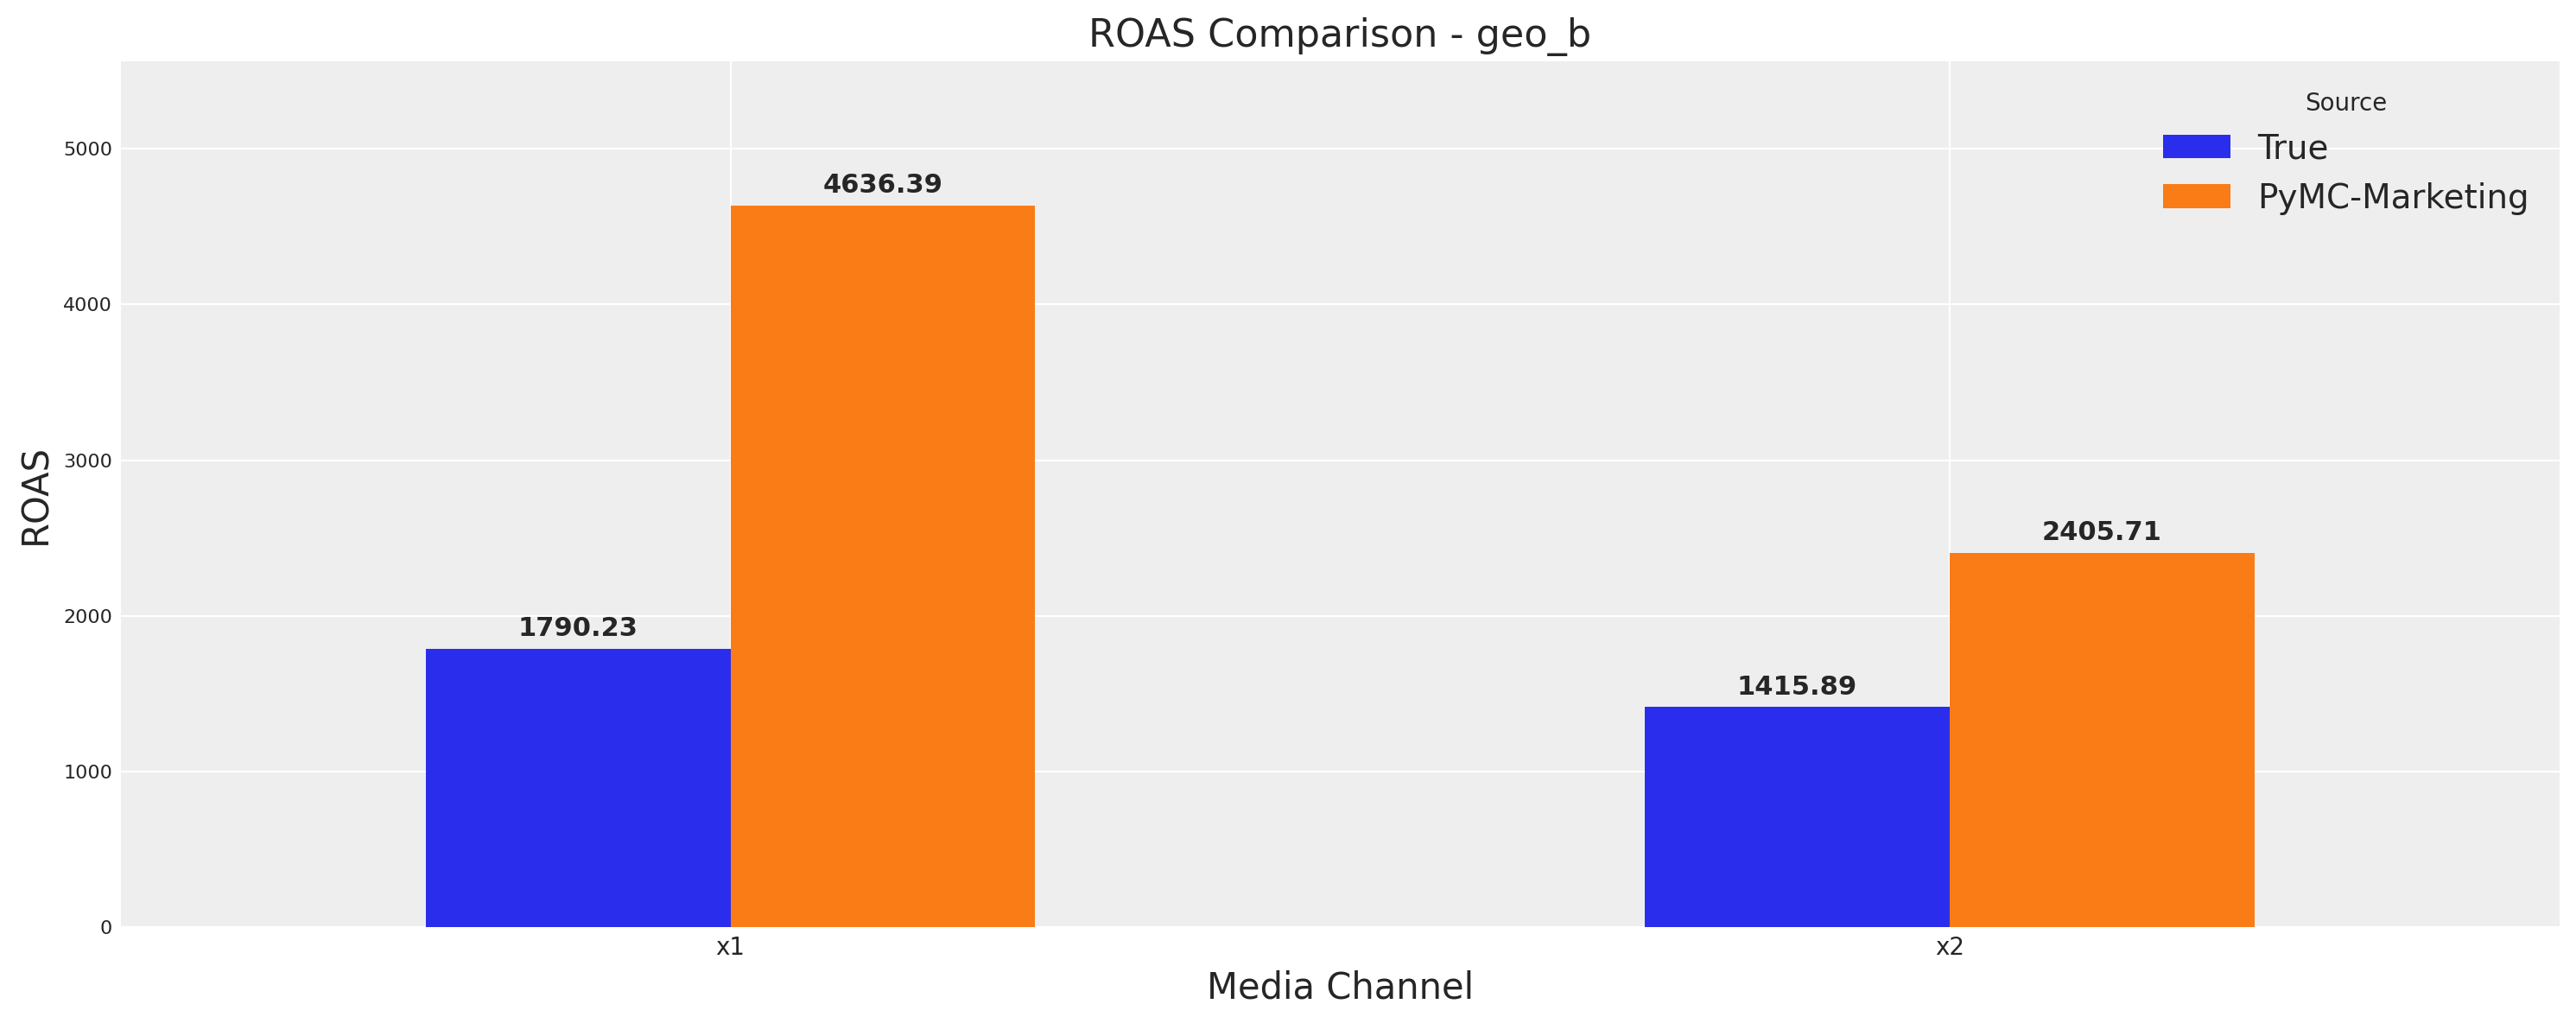

In [25]:
# --- STEP 1: Detect channels ---
channels = [col for col in data_df.columns if col.startswith("x")]
geos = data_df["geo"].unique()

# --- STEP 2: Compute TRUE ROAS ---
true_roas_dict = {}

for geo in geos:
    df_geo = data_df.query("geo == @geo").reset_index(drop=True)
    contrib_geo = true_contributions.query("geo == @geo").reset_index(drop=True)

    geo_roas = {}
    for ch in channels:
        spend = df_geo[ch].sum()
        revenue = contrib_geo[f"contrib_{ch}"].sum()
        roas = revenue / spend if spend > 0 else 0.0
        geo_roas[ch] = roas

    true_roas_dict[geo] = geo_roas

# --- STEP 3: Compute ESTIMATED ROAS ---
posterior_contrib = mmm.idata["posterior"]["channel_contribution_original_scale"]
mean_contrib = posterior_contrib.mean(dim=["chain", "draw"])

estimated_roas_dict = {}

for geo in geos:
    df_geo = data_df.query("geo == @geo").reset_index(drop=True)
    geo_roas = {}

    for ch in channels:
        predicted_revenue = mean_contrib.sel(geo=geo, channel=ch).values.sum()
        true_spend = df_geo[ch].sum()
        roas = predicted_revenue / true_spend if true_spend > 0 else 0.0
        geo_roas[ch] = roas

    estimated_roas_dict[geo] = geo_roas

# --- STEP 4: Plot Bar Charts by Geo ---
for geo in geos:
    true_roas = true_roas_dict[geo]
    estimated_roas = estimated_roas_dict[geo]

    # Align channels
    sorted_channels = sorted(true_roas.keys())
    roas_df = pd.DataFrame({
        "True": [true_roas[ch] for ch in sorted_channels],
        "PyMC-Marketing": [estimated_roas.get(ch, 0.0) for ch in sorted_channels],
    }, index=sorted_channels)

    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    roas_df.plot(kind="bar", ax=ax, color=["C0", "C1"])

    # Labels and formatting
    ax.set(
        title=f"ROAS Comparison - {geo}",
        xlabel="Media Channel",
        ylabel="ROAS"
    )
    ax.set_ylim(0, roas_df.values.max() * 1.2)

    for container in ax.containers:
        ax.bar_label(
            container,
            fmt="%.2f",
            label_type="edge",
            fontsize=11,
            fontweight="bold",
            padding=3
        )

    plt.xticks(rotation=0)
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()

In [26]:
roas_diff_dict = {}

for geo in geos:
    true_roas = true_roas_dict[geo]
    estimated_roas = estimated_roas_dict[geo]
    geo_diff = {}

    for ch in channels:
        true_val = true_roas.get(ch, 0)
        est_val = estimated_roas.get(ch, 0)

        if true_val == 0:
            pct_diff = np.nan
        else:
            pct_diff = 100 * (est_val - true_val) / true_val

        geo_diff[ch] = pct_diff

    roas_diff_dict[geo] = geo_diff

roas_diff_df = pd.DataFrame(roas_diff_dict).T
roas_diff_df = roas_diff_df[channels]

# Reformat rows: "{channel} ROAS PD", values as strings with %
formatted_rows = {}

for ch in channels:
    row_label = f"{ch} ROAS PD"
    formatted_rows[row_label] = [
        f"{roas_diff_df.loc[geo, ch]:.2f}%" if not pd.isna(roas_diff_df.loc[geo, ch]) else "N/A"
        for geo in roas_diff_df.index
    ]

roas_pd_df = pd.DataFrame(formatted_rows, index=roas_diff_df.index).T
roas_pd_df

geo_a    geo_b
x1 ROAS PD  143.41%  158.98%
x2 ROAS PD   82.63%   69.91%